<a href="https://colab.research.google.com/github/Merinroy010/CloudComputing/blob/master/res_prd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#

code has the 4 class


1.  **data.py**:  load  and split the data into training and testing. It also transform the data
2.   **Attention.py**  In this code attention is not specified. It assign weightage to inputs.

3.  **Model base**  Select models- the models included here are SA-LSTM, TA- LSTM, STA-LSTM, LSTM, FCN. We have selected the STA-LSTM in this code

4. **main.py**  Specify input and run specifications and call above classes. Run the model and save outputs  

5. **plot**  Plot outputs saved according to the date

6. **Model Performance **  using Root mean square error and volume biase












In [5]:
# data.py


import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset

# Implement data reading, data set partitioning and data output
class data_preprocess(object):

    def __init__(self, file_path = None, train_per = 0.80, vali_per = 0.0, in_dim = None):

        self.file_path = file_path
        self.train_per = train_per
        self.vali_per = vali_per
        self.in_dim = in_dim

    # Read the value of the csv file
    def load_data(self):

        raw_data = pd.read_csv(self.file_path).values
        # print('raw_data.shape = ',raw_data.shape)
        return raw_data

    # The split_data method splits the data into training, verification and test data. Each type of data contains dependent variables and true values.
    def  split_data(self, raw_data = None, _type = 'linear' ):

        length = len(raw_data)
        # print('Total amount of data set: {}'.format(length))
        train_set_size = int(length*self.train_per)
        vali_set_size = int(length*self.vali_per)
        test_set_size = int(length-train_set_size-vali_set_size)
        # print('Number of training sets: {}'.format(train_set_size),'\nNumber of validation sets: {}'.format(vali_set_size),'\nNumber of test sets: {}'.format(test_set_size))
        # print('Training set proportion: {}%'.format(self.train_per*100),'\nValidation set proportion: {}%'.format(self.vali_per*100),'\nTest set Proportion:{}%'.format((1-self.train_per-self.vali_per)*100))


        if _type == 'linear':

            train_data = raw_data[:train_set_size, :self.in_dim]
            vali_data = raw_data[train_set_size: train_set_size+vali_set_size, :self.in_dim]
            test_data = raw_data[train_set_size + vali_set_size:, :self.in_dim]
            train_groundtruth = raw_data[:train_set_size, self.in_dim:]
            vali_groundtruth = raw_data[train_set_size: train_set_size+vali_set_size, self.in_dim:]
            test_groundtruth = raw_data[train_set_size + vali_set_size:, self.in_dim:]
        else:

            pass
        return (train_data,train_groundtruth),(vali_data,vali_groundtruth),(test_data,test_groundtruth)


    # # Divide all the data obtained into a training set and a test set, and output them to an external csv file
    # def save_data(self, train_file_path = './train_set.csv', test_file_path = './test_set.csv'):
    #     train_set = pd.DataFrame([[0,0],[0,0]],index=['row1','row2'],columns=['column1','column2'])
    #     test_set = pd.DataFrame([[0,0],[0,0]],index=['row1','row2'],columns=['column1','column2'])
    #     train_set.to_csv(train_file_path,encoding = 'utf-8')
    #     test_set.to_csv(test_file_path,encoding = 'utf-8')
    # Implement data type conversion

class data_trans(Dataset):

    def __init__(self, data, groundtruth, transform=None):

        self.data = self._get_data(data)
        self.groundtruth = self._get_data(groundtruth)
        self.transform = transform

    def _get_data(self,data):
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self,index):

        inputs = self.data[index,:]
        groundtruths = self.groundtruth[index,:]
        #Convert data from numpy.array to tensor type
        if self.transform:

            inputs = torch.from_numpy(inputs).float()
            groundtruths = torch.from_numpy(groundtruths).float()

        return {'inputs':inputs,'groundtruths':groundtruths}

def main():
    # pass
    dp = data_preprocess(file_path = '/content/drive/MyDrive/AI-prediction/Res_prd_input/idukki_data_STA-LSTM.csv',train_per = 0.8, vali_per = 0.0, in_dim = 17)
    raw_data = dp.load_data()
    (train_data,train_groundtruth),(vali_data,vali_groundtruth),(test_data,test_groundtruth) = dp.split_data(raw_data = raw_data, _type = 'linear')
    print("done!")

if __name__ == '__main__':
    main()


done!


In [6]:
# Attention.py



import os
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.autograd import Variable

# from data import data_preprocess, data_trans
class STA_LSTM(nn.Module):

    def __init__(self,
                 in_dim,
                 sequence_length,
                 lstm_in_dim,
                 lstm_hidden_dim,
                 out_dim,
                 use_gpu=False):

        super(STA_LSTM,self).__init__()
        # Parameter Import Section
        self.in_dim = in_dim
        self.sequence_length = sequence_length
        self.lstm_in_dim = lstm_in_dim
        self.lstm_hidden_dim = lstm_hidden_dim
        self.out_dim = out_dim
        self.use_gpu = use_gpu

        # Network Structure Section
        # batch_norm layer
        self.bn = nn.BatchNorm1d(num_features=in_dim)

        # input layer
        self.layer_in = nn.Linear(in_dim, in_dim,bias=False)

        # spatial atteention module
        self.S_A = nn.Linear(lstm_in_dim, lstm_in_dim)

        # lstmcell
        self.lstmcell = nn.LSTMCell(lstm_in_dim, lstm_hidden_dim)

        # temporal atteention module, Generate sequence_length time weights, dimensions1 ×（lstm_hidden_dim + lstm_in_dim）-> 1 × sequence_length
        self.T_A = nn.Linear(sequence_length*lstm_hidden_dim, sequence_length)

        # # output layer, dimension 1 × lstm_hiddendim -> 1 × 1
        self.layer_out = nn.Linear(lstm_hidden_dim, out_dim,bias=False)

        # activate functions
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()

    def forward (self,input):

        # Batch Normalization Process Input
        out = self.bn(input)
        # print('batch_norm',out.size())
        # Processed by Input Layer
        out = self.layer_in(out)
        # print('layer_in',out.size())
       # Initialization Hidden State and Memory Unit State
        h_t_1 = torch.zeros(out.size(0), self.lstm_hidden_dim) # batch, hidden_size
        c_t_1 = torch.zeros(out.size(0), self.lstm_hidden_dim) # batch, hidden_size

        # Create a list to store ht
        h_list = []
        A = []
        for i in range(self.sequence_length):

            x_t = out[:,i*self.lstm_in_dim:(i+1)*(self.lstm_in_dim)]
            alpha_t =  self.sigmoid(self.S_A(x_t))
            alpha_t = self.softmax(alpha_t)
            a = np.array(alpha_t.data.numpy()).reshape((len(alpha_t.data.numpy()[0])))
            A.append(a)
            h_t,c_t = self.lstmcell(x_t*alpha_t,(h_t_1,c_t_1))
            h_list.append(h_t)
            h_t_1,c_t_1 = h_t,c_t

        np.savetxt('./models/A.csv',A, delimiter=',')

        total_ht = h_list[0]
        for i in range(1,len(h_list)):
            total_ht = torch.cat((total_ht,h_list[i]),1)

        beta_t =  self.relu(self.T_A(total_ht))
        beta_t = self.softmax(beta_t)
        B = np.array(beta_t.data.numpy()).reshape((len(beta_t.data.numpy()[0])))
        np.savetxt('./models/B.csv',B, delimiter=',')
        out = torch.zeros(out.size(0), self.lstm_hidden_dim)
        # print(h_list[i].size(),beta_t[:,1].size())

        for i in range(len(h_list)):
            out = out + h_list[i]*beta_t[:,i].reshape(out.size(0),1)
        out = self.layer_out(out)
        return out

'''****************************initialization*******************************'''
IN_DIM =  24       # Dependent variable TX144, CH96, HH120
SEQUENCE_LENGTH = 17   # Length of time series, that is, the backtracking period

LSTM_IN_DIM = int(IN_DIM/SEQUENCE_LENGTH)     # LSTM input size equal to total variable length/time series length
LSTM_HIDDEN_DIM = 300 # Size of LSTM hidden state

OUT_DIM = 1            # Output Size

LEARNING_RATE = 0.1 # learning rate
WEIGHT_DECAY = 1e-6    # L2 Penalty Item

BATCH_SIZE = 200        # batch size

EPOCHES = 90     # epoch size

TRAIN_PER = 0.80 # Training Set Ratio
VALI_PER = 0.0 # Validation Set Ratio


# Determine whether to use GPU acceleration
# USE_GPU = torch.cuda.is_available()
USE_GPU = False

net = STA_LSTM(IN_DIM,SEQUENCE_LENGTH,LSTM_IN_DIM,LSTM_HIDDEN_DIM,OUT_DIM,USE_GPU)

# trained_net = torch.load('/content/drive/MyDrive/AI-prediction/RES_MODEL/sta_lstm_90epoch.pth')
# net.load_state_dict(trained_net.state_dict())
# net.eval()

# sample_input = [[19,13,0.7,0.1,0,0.1,0,129,0,0,0.7,0.1,0,0.1,0,126,0,0,0.7,0.1,0,0.1,0,123,8,8,10,11.3,2,1.23,1,131,8,8,10,11.3,2,1.23,1,131,0,0,1.15,0.8,1,1.23,5,172.5,0,0,1.15,0.8,1,1.23,5,214,0,1,0.9,0.4,0,0.1,0,469,1,1,0.9,0.4,0,0.1,0,557.79,1,1,0.9,0.4,0,0.1,0,547.25,0,0,0.9,0.4,0,0.1,0,488.5,0,0,0.9,0.4,0,0.1,0,429.75]]

# sample_input = torch.tensor(sample_input)
# out = net(sample_input)

In [7]:
# modelbase.py



import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F


class SA_LSTM(nn.Module):

    def __init__(self,
                 in_dim,
                 sequence_length,
                 lstm_in_dim,
                 lstm_hidden_dim,
                 out_dim,
                 use_gpu=False):

        super(SA_LSTM,self).__init__()

        # Parameter import part

        self.in_dim = in_dim
        self.sequence_length = sequence_length

        self.lstm_in_dim = lstm_in_dim
        self.lstm_hidden_dim = lstm_hidden_dim
        self.out_dim = out_dim
        self.use_gpu = use_gpu

        #Network structure part

        # batch_norm layer
        self.batch_norm = nn.BatchNorm1d(in_dim)

        # input layer
        self.layer_in = nn.Linear(in_dim, in_dim,bias=False)

        # spatial atteention module
        self.S_A = nn.Linear(lstm_in_dim, lstm_in_dim)

        # lstmcell
        self.lstmcell = nn.LSTMCell(lstm_in_dim, lstm_hidden_dim)



        # # output layer, dimension 1 × lstm_hiddendim -> 1 × 1
        self.layer_out = nn.Linear(lstm_hidden_dim, out_dim,bias=False)

        # activate functions
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()

    def forward (self,input):

        # Batch normalize input
        out = self.batch_norm(input)
        # print('batch_norm',out.size())

        # Processed by the input layer
        out = self.layer_in(out)
        # print('layer_in',out.size())

        #Initialize hidden state and memory unit state
        h_t_1 = torch.zeros(out.size(0), self.lstm_hidden_dim) # batch, hidden_size
        c_t_1 = torch.zeros(out.size(0), self.lstm_hidden_dim) # batch, hidden_size

        for i in range(self.sequence_length):

            x_t = out[:,i*self.lstm_in_dim:(i+1)*(self.lstm_in_dim)]

            alpha_t =  self.sigmoid(self.S_A(x_t))

            alpha_t = self.softmax(alpha_t)

            h_t,c_t = self.lstmcell(x_t*alpha_t,(h_t_1,c_t_1))

            h_t_1,c_t_1 = h_t,c_t

        out = self.layer_out(h_t)

        return out

class TA_LSTM(nn.Module):

    def __init__(self,
                 in_dim,
                 sequence_length,
                 lstm_in_dim,
                 lstm_hidden_dim,
                 out_dim,
                 use_gpu=False):

        super(TA_LSTM,self).__init__()


        # Parameter import part

        self.in_dim = in_dim
        self.sequence_length = sequence_length

        self.lstm_in_dim = lstm_in_dim
        self.lstm_hidden_dim = lstm_hidden_dim
        self.out_dim = out_dim
        self.use_gpu = use_gpu

        #Network structure part

        # batch_norm layer
        self.batch_norm = nn.BatchNorm1d(in_dim)

        # input layer
        self.layer_in = nn.Linear(in_dim, in_dim,bias=False)


        # lstmcell
        self.lstmcell = nn.LSTMCell(lstm_in_dim, lstm_hidden_dim)


        # temporal atteention module, generates sequence_length temporal weights, dimension 1 × (lstm_hidden_dim + lstm_in_dim) -> 1 × sequence_length
        self.T_A = nn.Linear(sequence_length*lstm_hidden_dim, sequence_length)


        # # output layer, dimension 1 × lstm_hiddendim -> 1 × 1
        self.layer_out = nn.Linear(lstm_hidden_dim, out_dim,bias=False)

        # activate functions
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()

    def forward (self,input):

        # Batch normalize input
        out = self.batch_norm(input)
        # print('batch_norm',out.size())

        # Processed by the input layer
        out = self.layer_in(out)
        # print('layer_in',out.size())


        #Initialize hidden state and memory unit state
        h_t_1 = torch.zeros(out.size(0), self.lstm_hidden_dim) # batch, hidden_size
        c_t_1 = torch.zeros(out.size(0), self.lstm_hidden_dim) # batch, hidden_size


        #Create a list to store ht
        h_list = []

        for i in range(self.sequence_length):

            x_t = out[:,i*self.lstm_in_dim:(i+1)*(self.lstm_in_dim)]

            h_t,c_t = self.lstmcell(x_t,(h_t_1,c_t_1))

            h_list.append(h_t)

            h_t_1,c_t_1 = h_t,c_t

        total_ht = h_list[0]
        for i in range(1,len(h_list)):
            total_ht = torch.cat((total_ht,h_list[i]),1)

        beta_t =  self.relu(self.T_A(total_ht))
        beta_t = self.softmax(beta_t)

        out = torch.zeros(out.size(0), self.lstm_hidden_dim)
        # print(h_list[i].size(),beta_t[:,1].size())

        for i in range(len(h_list)):

            out = out + h_list[i]*beta_t[:,i].reshape(out.size(0),1)

        out = self.layer_out(out)

        return out

class STA_LSTM(nn.Module):

    def __init__(self,
                 in_dim,
                 sequence_length,
                 lstm_in_dim,
                 lstm_hidden_dim,
                 out_dim,
                 use_gpu=False):

        super(STA_LSTM,self).__init__()

        # Parameter import part

        self.in_dim = in_dim
        self.sequence_length = sequence_length

        self.lstm_in_dim = lstm_in_dim
        self.lstm_hidden_dim = lstm_hidden_dim
        self.out_dim = out_dim
        self.use_gpu = use_gpu

        #Network structure part

        # batch_norm layer
        self.bn = nn.BatchNorm1d(num_features=in_dim)

        # input layer
        self.layer_in = nn.Linear(in_dim, in_dim,bias=False)

        # spatial atteention module
        self.S_A = nn.Linear(lstm_in_dim, lstm_in_dim)

        # lstmcell
        self.lstmcell = nn.LSTMCell(lstm_in_dim, lstm_hidden_dim)


        # temporal atteention module, generates sequence_length temporal weights, dimension 1 × (lstm_hidden_dim + lstm_in_dim) -> 1 × sequence_length
        self.T_A = nn.Linear(sequence_length*lstm_hidden_dim, sequence_length)


        # # output layer, dimension 1 × lstm_hiddendim -> 1 × 1
        self.layer_out = nn.Linear(lstm_hidden_dim, out_dim,bias=False)

        # activate functions
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()




    def forward(self, input):
        # Batch normalization
        out = self.bn(input)

        # Input layer
        out = self.layer_in(out)

        # Initialize hidden states
        h_t_1 = torch.zeros(out.size(0), self.lstm_hidden_dim)
        c_t_1 = torch.zeros(out.size(0), self.lstm_hidden_dim)

        # List to store h_t
        h_list = []

        for i in range(self.sequence_length):
            x_t = out[:, i * self.lstm_in_dim: (i + 1) * self.lstm_in_dim]
            alpha_t = self.sigmoid(self.S_A(x_t))
            alpha_t = self.softmax(alpha_t)
            h_t, c_t = self.lstmcell(x_t * alpha_t, (h_t_1, c_t_1))
            h_list.append(h_t)
            h_t_1, c_t_1 = h_t, c_t

        total_ht = h_list[0]
        for i in range(1, len(h_list)):
            total_ht = torch.cat((total_ht, h_list[i]), 1)

        beta_t = self.relu(self.T_A(total_ht))
        beta_t = self.softmax(beta_t)

        out = torch.zeros(out.size(0), self.lstm_hidden_dim)
        for i in range(len(h_list)):
            out = out + h_list[i] * beta_t[:, i].reshape(out.size(0), 1)

        out = self.layer_out(out)

        return out





class LSTM(nn.Module):

    def __init__(self,
                 in_dim,
                 sequence_length,
                 lstm_in_dim,
                 lstm_hidden_dim,
                 out_dim,
                 use_gpu=False):

        super(LSTM,self).__init__()

        # Parameter import part

        self.in_dim = in_dim
        self.sequence_length = sequence_length

        self.lstm_in_dim = lstm_in_dim
        self.lstm_hidden_dim = lstm_hidden_dim
        self.out_dim = out_dim
        self.use_gpu = use_gpu

        #Network structure part

        # batch_norm layer
        self.batch_norm = nn.BatchNorm1d(in_dim)

        # input layer
        self.layer_in = nn.Linear(in_dim, in_dim)

        # lstmcell
        self.lstmcell = nn.LSTMCell(lstm_in_dim, lstm_hidden_dim)

        # # output layer, dimension 1 × lstm_hiddendim -> 1 × 1
        self.layer_out = nn.Linear(lstm_hidden_dim, out_dim,bias=False)

        # activate functions
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward (self,input):


        # Batch normalize input
        out = self.batch_norm(input)
        # print('batch_norm',out.size())

        # Processed by the input layer
        out = self.layer_in(out)

        # print('layer_in',out.size())

        #Initialize hidden state and memory unit state
        h_t_1 = torch.zeros(out.size(0), self.lstm_hidden_dim) # batch, hideden_size
        c_t_1 = torch.zeros(out.size(0), self.lstm_hidden_dim) # batch, hideden_size

        for i in range(self.sequence_length):

            x_t = out[:,i*self.lstm_in_dim:(i+1)*(self.lstm_in_dim)]

            h_t,c_t = self.lstmcell(x_t,(h_t_1,c_t_1))
            h_t_1,c_t_1 = h_t,c_t

        out = self.layer_out(h_t)

        return out

class FCN(nn.Module):

    def __init__(self,
                 in_dim,
                 sequence_length,
                 lstm_in_dim,
                 lstm_hidden_dim,
                 out_dim,
                 use_gpu=False):

        super(FCN, self).__init__()

        # Parameter import part

        self.in_dim = in_dim
        self.sequence_length = sequence_length

        self.lstm_in_dim = lstm_in_dim
        self.lstm_hidden_dim = lstm_hidden_dim

        self.out_dim = out_dim
        self.use_gpu = use_gpu

        #Network structure part

        # batch_norm layer
        self.batch_norm = nn.BatchNorm1d(in_dim)

        # input layer
        self.layer_in = nn.Linear(in_dim, in_dim,bias=False)

        # fcn
        self.fcn = nn.Linear(in_dim, lstm_hidden_dim)

        # # output layer, dimension 1 × lstm_hiddendim -> 1 × 1
        self.layer_out = nn.Linear(lstm_hidden_dim, out_dim,bias=False)

        # activate functions
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward (self,input):


        # Batch normalize input
        out = self.batch_norm(input)
        # print('batch_norm',out.size())

        # Processed by the input layer
        out = self.layer_in(out)
        # print('layer_in',out.size())

        out = self.sigmoid(out)

        out = self.fcn(out)

        out = self.sigmoid(out)

        out = self.layer_out(out)

        return out


def main():

    in_dim = 34
    sequence_length = 17
    lstm_in_dim = 2
    lstm_hidden_dim = 64
    out_dim = 1
    batch_size = 200
    input = torch.randn(batch_size, 34)

    batch_norm = nn.BatchNorm1d(in_dim)
    in_linear = nn.Linear(in_dim, in_dim)

    out = batch_norm(input)
    print(out.size())

    out = in_linear(out)
    print(out.size())

    h = torch.zeros(batch_size, lstm_hidden_dim)
    c = torch.zeros(batch_size, lstm_hidden_dim) # batch,hideden_size

    lstmcell = nn.LSTMCell(lstm_in_dim, lstm_hidden_dim)

    for i in range(sequence_length):

        temp_out = out[:,i*lstm_in_dim:(i+1)*(lstm_in_dim)]

        print(temp_out.size())

        h,c = lstmcell(temp_out,(h,c))

        print(h.size())
        print(h)


if __name__ == '__main__':
    main()



torch.Size([200, 34])
torch.Size([200, 34])
torch.Size([200, 2])
torch.Size([200, 64])
tensor([[ 0.0108, -0.0789, -0.0375,  ..., -0.0026,  0.0498,  0.0642],
        [ 0.0262, -0.0569, -0.0248,  ..., -0.0175,  0.0278,  0.0560],
        [ 0.0518, -0.0227, -0.0015,  ..., -0.0402, -0.0072,  0.0414],
        ...,
        [ 0.0387, -0.0400, -0.0139,  ..., -0.0284,  0.0107,  0.0494],
        [ 0.0314, -0.0447, -0.0180,  ..., -0.0312,  0.0159,  0.0442],
        [ 0.0459, -0.0226, -0.0017,  ..., -0.0466, -0.0060,  0.0318]],
       grad_fn=<MulBackward0>)
torch.Size([200, 2])
torch.Size([200, 64])
tensor([[ 0.0392, -0.0809, -0.0330,  ..., -0.0308,  0.0439,  0.0751],
        [ 0.0541, -0.0461, -0.0079,  ..., -0.0611,  0.0094,  0.0419],
        [ 0.0368, -0.0852, -0.0330,  ..., -0.0309,  0.0381,  0.0813],
        ...,
        [ 0.0583, -0.0555, -0.0143,  ..., -0.0510,  0.0113,  0.0663],
        [ 0.0314, -0.0819, -0.0382,  ..., -0.0426,  0.0397,  0.0624],
        [ 0.0269, -0.0918, -0.0425,  ..., 

In [4]:
# import pandas as pd

# # Step 1: Read the existing DataFrame from the CSV file
# df = pd.read_csv('/content/drive/MyDrive/AI-prediction/Res_prd_input/idukki_data_STA-LSTMcsv.csv')
# # # Step 2: Print the column names
# # print(df.index)

# # Step 2: Remove the date column (replace 'date_column_name' with the actual name of the date column)
# # df = df.drop(df['Date'])
# df = df.drop(columns=['Date'])

# # # Step 3: Save the modified DataFrame to a new CSV file
# df.to_csv('/content/drive/MyDrive/AI-prediction/Res_prd_input/idukki_data_STA-LSTM.csv', index=False)

/content
starting training... 


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch

epoch = 1,loss = 70.05545
training time = 12s
(363,)
(363,)
[17.64520264 17.46975708 16.95311165 14.26338196  2.33667994  1.12134027
  1.46675074  1.49888074  1.5415194   1.67916     1.70732164  1.61466432
  1.32279289  1.63404036  1.61816013  1.65965962  1.23452902  1.73024118
  1.72714841  2.58818817  1.47868156  1.65602577  1.67299151  1.66484499
  1.65788293  1.68212688  1.12307668  1.53845954  1.55010509  1.53028154
  1.66489685  1.73185229  1.67144156  1.61793673  1.57979524  1.69826567
  1.24825287 15.01131344 13.09103203  0.95573688  8.36616898  1.21051097
  3.31615353  4.74801493  3.19633174 13.55386162 15.29899311  1.83615172
  1.66079175 11.5363102   9.44318771  1.34569156  1.19961441  5.66630363
  3.1256609   0.92844081  0.91461396  1.35080087  1.01193309  0.90866154
  8.52704906 12.47435951  9.55378914  0.91510344  1.11086202  0.95563591
  1.17251539 12.4640131  14.61610413 16.95184708 16.26868248 10.47368526
  0.92371309  1.20835042  1.3184433   1.40969014  1.72383571  8.

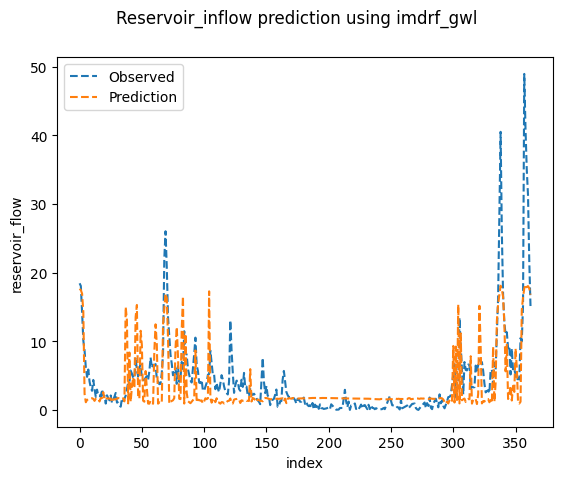

In [10]:

import os
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt

# from data import data_preprocess, data_trans
# from modelbase import STA_LSTM as Net
# from modelbase import SA_LSTM as Net
# from modelbase import TA_LSTM as Net
# from modelbase import LSTM as Net
# from modelbase import FCN as Net
# from modelbase import SVM as Net
print(os.getcwd())
'''****************************initialization*******************************'''
IN_DIM =  24       # Dependent variable TX144, CH96, HH120
SEQUENCE_LENGTH = 17   # The length of the time series, which is the lookback period

LSTM_IN_DIM = int(IN_DIM/SEQUENCE_LENGTH)     #The input size of LSTM is equal to the total variable length/time series length
LSTM_HIDDEN_DIM = 300  #The size of LSTM hidden state

OUT_DIM = 1            # Output size

LEARNING_RATE = 0.05 # learning rate
WEIGHT_DECAY = 1e-6    # L2 penalty term

BATCH_SIZE = 200        # batch size

EPOCHES = 1  # epoch size

TRAIN_PER = 0.80 #Training set proportion
VALI_PER = 0.0 # Proportion of verification set

# Determine whether to use GPU acceleration
# USE_GPU = torch.cuda.is_available()
USE_GPU = False

Net=STA_LSTM





'''****************************data prepration*******************************'''

# Prepare training and test data
dp = data_preprocess(file_path = '/content/drive/MyDrive/AI-prediction/Res_prd_input/idukki_data_STA-LSTM.csv', train_per = TRAIN_PER, vali_per = VALI_PER, in_dim = IN_DIM)

raw_data = dp.load_data()

#print('Data import completed')

(train_data,train_groundtruth),(vali_data,vali_groundtruth),(test_data,test_groundtruth) = dp.split_data(raw_data = raw_data, _type = 'linear')

# print('Data splitting completed')


# Set the method of data transformation. The function of transform.compose is to combine multiple transforms together for use.
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean=(0,0,0),std=(1,1,1))])
# print('data converted to tensor')

# The value returned by data_trans is a dictionary containing data and truth values ​​{'inputs':inputs,'groundtruth':groundtruths}

# Prepare training set
train_data_trans = data_trans(train_data,train_groundtruth,transform)

train_dataloader = torch.utils.data.DataLoader(train_data_trans,
                                           batch_size =BATCH_SIZE,
                                           shuffle = True,
                                           num_workers = 4)

# print('Training set prepared')

# Prepare test set
test_data_trans = data_trans(test_data, test_groundtruth,transform)

test_dataloader = torch.utils.data.DataLoader(test_data_trans,
                                           batch_size = BATCH_SIZE,
                                           shuffle = False,
                                           num_workers = 4)

# print('Test set prepared')


'''****************************model prepration*******************************'''

# Import network parameters into the network
net = Net(IN_DIM,SEQUENCE_LENGTH,LSTM_IN_DIM,LSTM_HIDDEN_DIM,OUT_DIM,USE_GPU)
# print('Network model is ready')


# Determine whether the GPU is available. If available, change the net into a GPU-accelerated net.
if USE_GPU:
    net = net.cuda()
    # print('This experiment uses GPU acceleration')
else:
    pass
    # print('This experiment does not use GPU acceleration')

# Use SGD (stochastic gradient descent) optimization with a learning rate of 0.001 and a momentum of 0.9
# optimizer = optim.SGD(net.parameters(), lr= LEARNING_RATE, momentum=0.9)
# Adjust parameter values ​​according to gradient, Adam algorithm
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# The learning rate is adjusted according to the number of training times
adjust_lr = optim.lr_scheduler.MultiStepLR(optimizer,
                                     milestones=[i*10 for i in range(EPOCHES//10)],
                                     gamma=0.5)


# Define training loss function & test error function
# loss_criterion = nn.SmoothL1Loss()
loss_criterion = nn.MSELoss()
error_criterion = nn.MSELoss()



def train(verbose = False):

    net.train()
    loss_list = []

    for i,data in enumerate(train_dataloader):

        inputs = data['inputs']
        groundtruths = data['groundtruths']

        if USE_GPU:
            inputs = Variable(inputs).cuda()
            groundtruths = Variable(groundtruths).cuda()

        else:
            inputs = Variable(inputs)
            groundtruths = Variable(groundtruths)


        #Initialize the grad value of the parameter to 0
        optimizer.zero_grad()


        #Get network output results
        out = net(inputs)


        #Calculate the value of the loss function based on the true value
        loss = loss_criterion(out,groundtruths)

        #Optimize the network through the optimizer
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())

    return loss_list





def test():

    # error = 0.0
    predictions = []
    test_groundtruths = []

    # Tell the network to test, no longer in training mode
    net.eval()

    for i,data in enumerate(test_dataloader):

        inputs = data['inputs']
        groundtruths = data['groundtruths']

        if USE_GPU:

            inputs = Variable(inputs).cuda()
            groundtruths = Variable(groundtruths).cuda()

        else:

            inputs = Variable(inputs)
            groundtruths = Variable(groundtruths)

        out = net(inputs)
        # error += (error_criterion(out,groundtruths).item()*groundtruths.size(0))

        if USE_GPU:
            predictions.extend(out.cpu().data.numpy().tolist())
            test_groundtruths.extend(groundtruths.cpu().data.numpy().tolist())

        else:
            predictions.extend(out.data.numpy().tolist())
            test_groundtruths.extend(groundtruths.data.numpy().tolist())

    # # average_error = np.sqrt(error/len(test_data_trans))
    # print(len(predictions))
    # print(len(test_groundtruths))

    return np.array(predictions).reshape((len(predictions))),np.array(test_groundtruths).reshape((len(test_groundtruths)))
    return np.array(predictions),np.array(test_groundtruths)


    import matplotlib.pyplot as plt
def main():

    #Record the time when the program starts
    train_start = time.time()
    loss_recorder = []

    print('starting training... ')

    for epoch in range(EPOCHES):

        # adjust learning rate
        adjust_lr.step()

        loss_list = train(verbose= True)

        loss_recorder.append(np.mean(loss_list))

        print('epoch = %d,loss = %.5f'%(epoch+1,np.mean(loss_list)))

    print ('training time = {}s'.format(int((time.time() - train_start))))

    # Record the time when the test starts
    test_start = time.time()


    predictions, test_groundtruth = test()

    print(predictions.shape)
    print(test_groundtruth.shape)
    print(predictions)
    print(test_groundtruth)

    print('test time = {}s'.format(int((time.time() - test_start)+1.0)))

    # save out put
    result = pd.DataFrame(data = {'prd_60_1':predictions,'obs':test_groundtruth})
    result.to_csv('/content/drive/MyDrive/AI-prediction/RES_Output/res_prd_60_epoch', index=False)


    # # # save to  the existing file
    # df = pd.read_csv('/content/drive/MyDrive/AI-prediction/RES_Output/res_prd_90_epoch')
    # result = pd.DataFrame(data = {'prd_60':predictions,'obs':test_groundtruth})
    # df['prd_60'] = predictions
    # df.to_csv('/content/drive/MyDrive/AI-prediction/RES_Output/res_prd_90_epoch', index=False)

    # Assuming 'result' is the DataFrame containing 'predictions' and 'test_groundtruth'
    fig = plt.figure()
    ax = fig.add_subplot()
    color = 'tab:blue'
    ax.set_xlabel('index')

    ax.plot(result['obs'], label='Observed', linestyle='dashed')
    ax.plot(result['prd_60_1'], label='Prediction', linestyle='dashed')

    ax.set_ylabel('reservoir_flow')
    # ax.set_ylim(12, 4)  # Uncomment this line if you want to set a specific y-axis limit
    ax.legend()

    plt.suptitle('Reservoir_inflow prediction using imdrf_gwl')
    # torch.save(net,'/content/drive/MyDrive/AI-prediction/RES_MODEL/sta_lstm_60epoch.pth')

if __name__ == '__main__':
    main()



Index(['Unnamed: 0', 'prd', 'obs', 'prd_100', 'prd_60'], dtype='object')


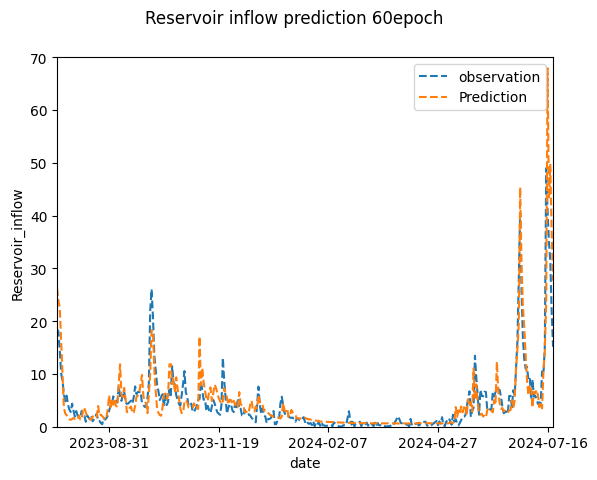

In [9]:
#plot for the saved data

import matplotlib.dates as mdates
import matplotlib.pyplot as plt


# Read the CSV file
date_df = pd.read_csv(''/content/drive/MyDrive/AI-prediction/Res_prd_input/idukki_data_STA-LSTM_date.csv'')

# Calculate the index of the 80% mark
eighty_percent_index = int(len(date_df) * 0.8)

# Get the last 20% of the date range
last_20_percent_dates = date_df['Date'].iloc[eighty_percent_index:]

# Convert the date column to datetime format
date_range = pd.to_datetime(last_20_percent_dates, format='%Y-%m-%d')

df = pd.read_csv(''/content/drive/MyDrive/AI-prediction/Res_prd_input/idukki_data_STA-LSTM.csv'')

print(df.columns)


fig = plt.figure()
ax = fig.add_subplot()
color = 'tab:blue'
ax.set_xlabel('date')

# date_range = generate_dates(df)
ax.plot(date_range, df['obs'], label='observation', linestyle='dashed')
ax.plot(date_range, df['prd_60'], label='Prediction', linestyle='dashed')

ax.set_ylabel('Reservoir_inflow')
ax.set_ylim(0, 70)
ax.legend()
start_date = date_range.min()
end_date = date_range.max()
ax.set_xlim([start_date, end_date, ])
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
# Save the plot
plt.savefig('/content/drive/MyDrive/AI-prediction/RES_Output/plot/Res_prd_60epoch.png')

plt.suptitle('Reservoir inflow prediction 60epoch ')
plt.show()



RMSE for prd_60: 3.4121216783262662
RMSE for prd_90: 3.2669929000235545
RMSE for prd_100: 3.257125686875296


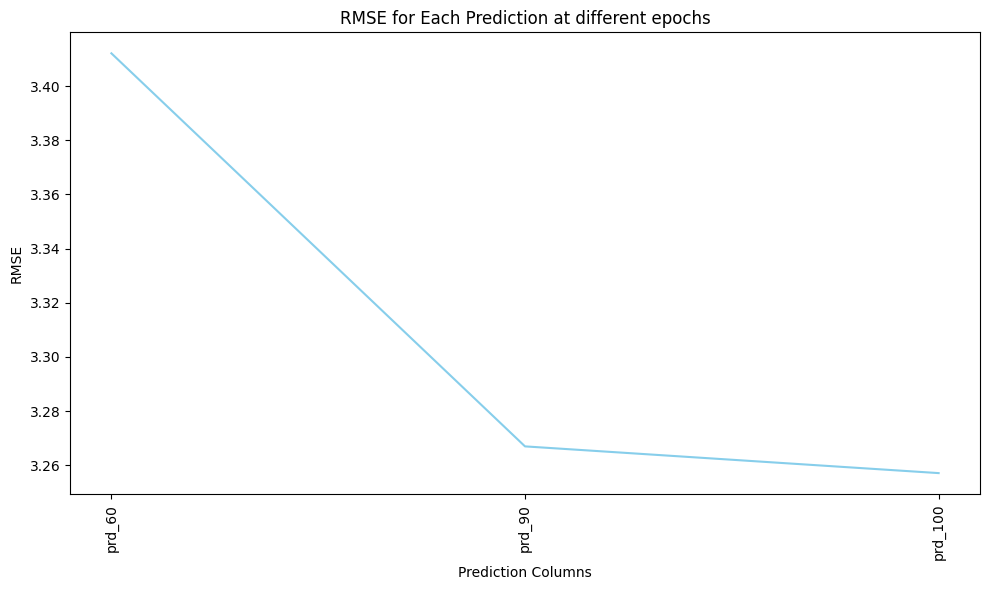

In [11]:
# performance


# import libraries
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np



# # Step 1: Read the CSV file
# df = pd.read_csv('/content/drive/MyDrive/AI-prediction/RES_Output/res_prd_90_epoch')

# # Step 2: Remove the first column
# df = df.drop(df.columns[0], axis=1)  # Drop the first column by index
# df = df.rename(columns={'prd': 'prd_90'})

# # Ensure these columns exist in the DataFrame
# # Adjust the column names based on the original DataFrame structure
# df = df[['obs', 'prd_60', 'prd_90', 'prd_100']]
# df.to_csv('/content/drive/MyDrive/AI-prediction/RES_Output/res_prd.csv', index=False)


# # Display the modified DataFrame
# print(df.head())



df= pd.read_csv('/content/drive/MyDrive/AI-prediction/Input/input_test.csv')
obs= 'obs'
prd = [col for col in df.columns if col != obs]

# Function to calculate RMSE
def calculate_rmse(observed, predicted):
    return np.sqrt(((observed - predicted) ** 2).mean())
# Calculate RMSE for each prediction column
rmse_results = {}
for col in prd:
    rmse = calculate_rmse(df[obs], df[col])
    rmse_results[col] = rmse

# Print the RMSE results
for col, rmse in rmse_results.items():
    print(f'RMSE for {col}: {rmse}')

import matplotlib.pyplot as plt
# Plot the RMSE results
plt.figure(figsize=(10, 6))
plt.plot(rmse_results.keys(), rmse_results.values(), color='skyblue')
plt.xlabel('Prediction Columns')
plt.ylabel('RMSE')
plt.title('RMSE for Each Prediction at different epochs')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

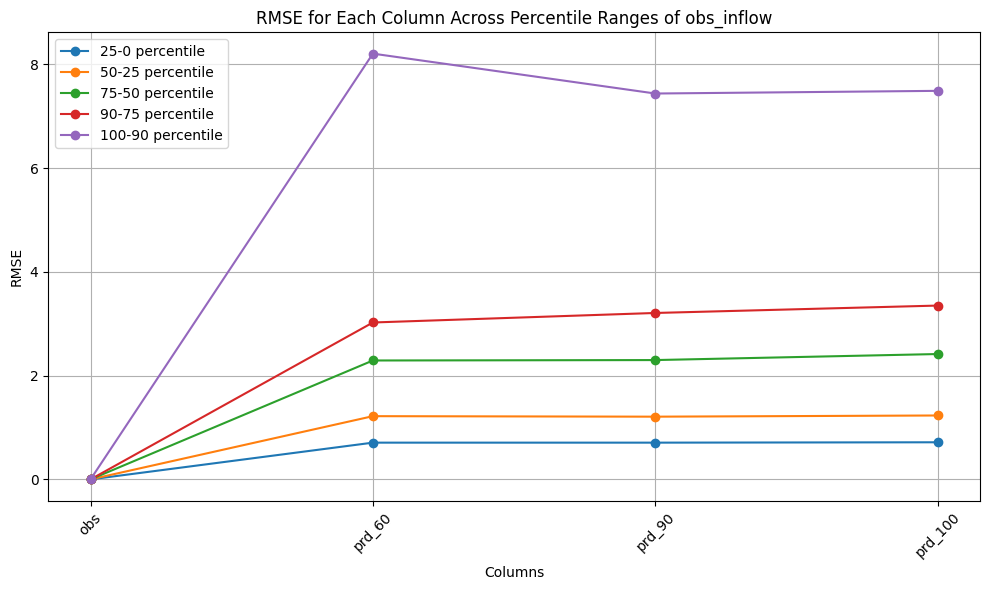

In [29]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Function to calculate RMSE
def calculate_rmse(observed, predicted):
    return np.sqrt(mean_squared_error(observed, predicted))

# Function to categorize values based on percentiles
def categorize_values(df, percentile_divisions):
    # Calculate percentiles
    percentiles = np.percentile(df['obs'], percentile_divisions)

    # Categorize each value based on percentiles
    categories = np.digitize(df['obs'], percentiles)

    return categories

# Read the CSV file
df = pd.read_csv('/content/drive/MyDrive/AI-prediction/Input/input_test.csv')

# Define percentile divisions (0-25, 25-50, 50-75, 75-90, 90-100)
percentile_divisions = [100, 90, 75, 50, 25, 0]

# Reverse the percentile divisions
percentile_divisions.reverse()

# Categorize values based on reversed percentiles
df['category'] = categorize_values(df, percentile_divisions)

# Initialize dictionary to store RMSE results for each column
rmse_results = {}

# Calculate RMSE for each column and each category
for col in df.columns[1:]:  # Exclude the first column 'obs_inflow'
    rmse_results[col] = []
    for category in range(1, len(percentile_divisions)):
        subset_df = df[df['category'] == category]
        observed = subset_df['obs']
        predicted = subset_df[col]
        rmse = calculate_rmse(observed, predicted)
        rmse_results[col].append(rmse)

# Convert results to DataFrame for plotting
rmse_df = pd.DataFrame(rmse_results)

# Transpose the DataFrame to have columns as indices
rmse_df = rmse_df.T

# Set the column names as Percentile Range
rmse_df.columns = [f'{percentile_divisions[i+1]}-{percentile_divisions[i]} percentile' for i in range(len(percentile_divisions)-1)]

# Plot the RMSE results as a line plot (excluding 'category')
plt.figure(figsize=(10, 6))
for col in rmse_df.columns:
    plt.plot(rmse_df.index, rmse_df[col], marker='o', linestyle='-', label=col)

plt.xlabel('Columns')
plt.ylabel('RMSE')
plt.title('RMSE for Each Column Across Percentile Ranges of obs_inflow')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def calculate_v_bias(observed, predicted):
    return np.where(observed == 0, 0, (observed - predicted) / observed)

def categorize_values(df, percentile_divisions):
    percentiles = np.percentile(df['obs_inflow'], percentile_divisions)
    categories = np.digitize(df['obs_inflow'], percentiles)
    return categories

df = pd.read_csv('/content/drive/MyDrive/AI-prediction/Input/input_test.csv')

percentile_divisions = [0, 25, 50, 75, 90, 100]

df['category'] = categorize_values(df, percentile_divisions)

v_bias_results = pd.DataFrame(index=range(1, len(percentile_divisions)))

# Exclude the 'category' column from the DataFrame before transposing
v_bias_results = v_bias_results.drop('category', axis=1, errors='ignore')
print(v_bias_results)

for col in df.columns[1:]:
    v_bias_results[col] = [calculate_v_bias(subset_df['obs_inflow'], subset_df[col]).mean()
                           for category in range(1, len(percentile_divisions))
                           for subset_df in [df[df['category'] == category]]]

plt.figure(figsize=(10, 6))
v_bias_results.boxplot(rot=45)
plt.xlabel('Columns')
plt.ylabel('V_bias')
plt.title('Box Plot of V_bias for Each Column Across Percentile Ranges of obs_inflow')
plt.tight_layout()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')